In [1]:
import matplotlib.pyplot as plt
import numpy as np
from numpy import e as e
from scipy.constants import g, R
from scipy.integrate import solve_ivp

In [2]:
# water properties
rho_l = 997         #[kg/m^3]
rgas_v = 461.5      #[J/Kg/K]
latent_v = 2.5e6

# droplet solute properties
m_sol          = 1e-16                              # mass of solute dissovled [g]
mr_sol         = 58                                # Mr of solute [g/mol]
ionic          = 2                                  # degree ionic dissociation (van't Hoff factor)

# parcel properties
w               = 2                                             # vertical wind speed [m/s]
z0              = 0                                             # initial z coordinate
temp, p         = 293, 80000                                    # temp & pressure
s               = 1.005                                         # supersaturatiion

# integration params
args = [temp, p, w, m_sol, mr_sol, ionic]
t_span, t_eval = [0,1200], np.linspace(0,1200,120)

In [3]:
def diffusion_growth(t, y, temp, p, w, m_sol, mr_sol, ionic):
    
    ''' diffusion growth of droplets under fixed temp, p, and saturation'''
    
    z = y[0]
    r = y[1:]
    
    psat = 611.2 * np.exp(latent_v/rgas_v * (1/273.15 - 1/temp))   #[eq.2.60 lohmann intro 2 clouds]
    thermk = 4.1868e-3 * (5.69 + 0.017*(temp-273.15))             #[eq.7.24 lohmann intro 2 clouds]
    diffuse_v = 2.11e-5 * (temp/273.15)**1.94 * (101325/p)       #[eq.7.26 lohmann intro 2 clouds]
    
    fkl = (latent_v/(rgas_v*temp) -1)*latent_v/(thermk*temp)
    fdl = rgas_v*temp/(diffuse_v*psat)
    
    # r_activation = sqrt(3b/a), S_activation = 1+sqrt(4a^3/27b)
    a = 3.3e-7/temp                                                       #2*surface_tens (=0.0756N/m)/(rho_l*rgas_v*temp) [eq.6.24]
    b = 43e-6*m_sol*ionic/mr_sol                                               #43e-6 m^3/mol * mass_solute/ Mr_solute [eq.6.22]
    
    dz = w
    #dr = ((s-1))/ (rho_l * (fkl+fdl) *r)                                #[eq.7.27 lohmann intro 2 clouds]
    dr = ((s-1) -a/r +b/r**3)/ (rho_l * (fkl+fdl) *r)                       #[eq.7.27 lohmann intro 2 clouds]
    
    dy = [dz]
    dy.extend(dr)
    
    
    return dy

In [4]:
#r0 = np.asarray([0.01, 0.1, 1, 10])*1e-6

logr_edges = np.linspace(-8.91,-5.58,10)    #edges to lnr bins
del_logr = logr_edges[1:]-logr_edges[:-1]
logr = (logr_edges[1:]+logr_edges[:-1])/2  
r0 = 10**logr

y0 = [z0]
y0.extend(r0)

sol = solve_ivp(diffusion_growth, t_span, y0, method='RK45', t_eval=t_eval, args=args)      # max_step not specified
time = sol.t
z = sol.y[0]
r = sol.y[1:]



# analytical solution (assuming no kelvin & Raoult factors
s = 1.005
psat = 611.2 * np.exp(latent_v/rgas_v * (1/273.15 - 1/temp))   #[eq.2.60 lohmann intro 2 clouds]
thermk = 4.1868e-3 * (5.69 + 0.017*(temp-273.15))             #[eq.7.24 lohmann intro 2 clouds]
diffuse_v = 2.11e-5 * (temp/273.15)**1.94 * (101325/p)       #[eq.7.26 lohmann intro 2 clouds]
fkl = (latent_v/(rgas_v*temp) -1)*latent_v/(thermk*temp)
fdl = rgas_v*temp/(diffuse_v*psat)
analy_sol = [np.sqrt(r**2 + 2*(s-1)/(rho_l*(fkl+fdl))*time) for r in r0]

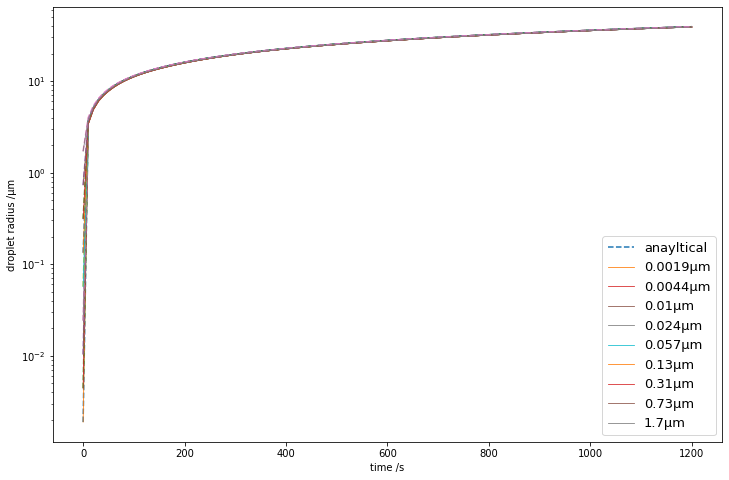

In [5]:
fig, ax = plt.subplots(figsize=(12,8))
#cols = ['b','g','r','c','m','y','k']
labs = ['{:.2g}\u03BCm'.format(r*1e6) for r in r0]
labs2 = [None]*len(r0)
labs2[0]='anayltical'
for i, sol in enumerate(analy_sol):
    ax.plot(time, sol*1e6, '--', label=labs2[i]) #color=cols[i] )
    ax.plot(time, r[i]*1e6, linewidth=0.8, label=labs[i]) #,color=cols[i])
ax.set_xlabel('time /s')
ax.set_ylabel('droplet radius /\u03BCm')
ax.set_yscale('log')
ax.legend(fontsize=13)

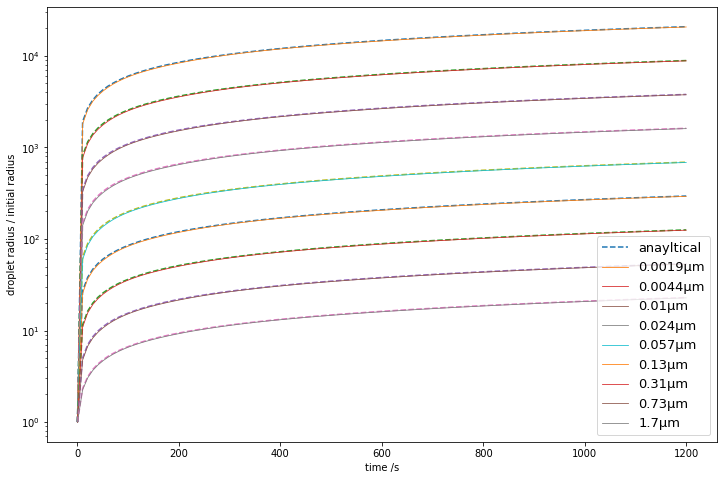

In [6]:
fig, ax = plt.subplots(figsize=(12,8))
#cols = ['b','g','r','c','m','y','k']
labs = ['{:.2g}\u03BCm'.format(r*1e6) for r in r0]
labs2 = [None]*len(r0)
labs2[0]='anayltical'
for i, sol in enumerate(analy_sol):
    ax.plot(time, sol/sol[0], '--', label=labs2[i]) #color=cols[i] )
    ax.plot(time, r[i]/r[i,0], linewidth=0.8, label=labs[i]) #,color=cols[i])
ax.set_xlabel('time /s')
ax.set_ylabel('droplet radius / initial radius')
ax.set_yscale('log')
ax.legend(fontsize=13)

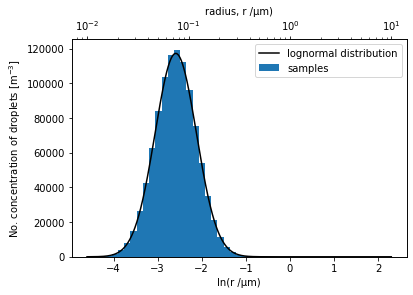

In [7]:
def lnnormal_dist(r, n_a, mu, sig):
    ''' return number concentration (n [m^-3])
    of particles with radius r in bin of unit length 
    on logarithmic scale based on monomodal 
    lognormal distribution. ie. No particles per cm"^-3
    in bin at radius r of width delta(lnr), n =
    dn_dlnr * delta(lnr)'''
    
    sigtilda = np.log(sig)
    mutilda = np.log(mu)
    norm = n_a/(np.sqrt(2*np.pi)*sigtilda)
    
    dn_dlnr = norm*np.exp(-(np.log(r)-mutilda)**2/(2*sigtilda**2))   #eq.5.8

    return dn_dlnr


def get_lnr_dist(rs, nbins, n_a, mu, sig):
    
    edgs = np.linspace(np.log(rs[0]), np.log(rs[1]), nbins)    #edges to lnr bins
    wdths = edgs[1:]- edgs[:-1]
    lnr = (edgs[1:]+edgs[:-1])/2
    lnnorm = lnnormal_dist(np.e**lnr, n_a, mu, sig) 
    
    return lnr, lnnorm, wdths, edgs


def plot_lognormal_dist(ndrops, lnr, lnnorm, wdths, edgs):
     
    fig, ax = plt.subplots()
    
    ax.bar(lnr+np.log(1e6), ndrops, wdths, label='samples')
    
    ax1 = ax.twiny()
    linear_wdths = np.e**edgs[1:] - np.e**edgs[:-1]
    ax1.bar(np.e**lnr*1e6, ndrops, linear_wdths*1e6, alpha=0)
    ax1.set_xscale('log')
    
    ax.set_xlabel('ln(r /\u03BCm)')
    ax.set_ylabel('No. concentration of droplets [m$^{-3}$]')
    ax1.set_xlabel('radius, r /\u03BCm)')
    
    pltlnr, pltnorm, pltwdths = get_lnr_dist(r_span, nbins*100, n_a, mu, sig)[0:3]
    ax.plot(pltlnr+np.log(1e6), pltnorm*pltwdths*100, color='k', label='lognormal distribution')
    
    ax.legend()

n_a = 1e6 #[m^-3]       #total no. concentration of particles
mu =  0.075e-6 #m
sig = 1.6
r_span = [1e-8, 1e-5]               # radii over which to sample distribution
nbins = 50                         # no. of sample bins to have (linear in log space)

lnr, lnnorm, wdths, edgs = get_lnr_dist(r_span, nbins, n_a, mu, sig)
ndrops = [int(n) for n in lnnorm*wdths]

plot_lognormal_dist(ndrops, lnr, lnnorm, wdths, edgs)

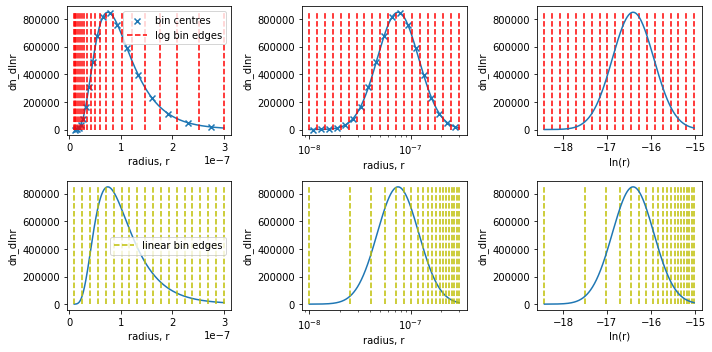

In [8]:
n_a = 1e6 #[m^-3]       #total no. concentration of particles
mu =  0.075e-6 #m
sig = 1.6
r_span = [1e-8, 3e-7]               # radii over which to sample distribution
nbins = 20                         # no. of sample bins to have (linear in log space)


lnr, lnnorm, wdths, edgs = get_lnr_dist(r_span, nbins, n_a, mu, sig)
ndrops = [int(n) for n in lnnorm*wdths]

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(10,5))
axs = axs.flatten()

pltlnr, pltnorm = get_lnr_dist(r_span, nbins*100, n_a, mu, sig)[0:2]

axs[0].scatter(e**lnr, ndrops/wdths, marker='x', label='bin centres')
axs[1].scatter(e**lnr, ndrops/wdths, marker='x')
for ax in [axs[0], axs[1], axs[3], axs[4]]:
    ax.plot(e**pltlnr, pltnorm)
    ax.set_ylabel('dn_dlnr')
    ax.set_xlabel('radius, r')

axs[0].vlines(e**edgs, 0, np.amax(lnnorm), color='r', linestyles='--', label='log bin edges')
axs[1].vlines(e**edgs, 0, np.amax(lnnorm), color='r', linestyles='--')
axs[2].vlines(edgs, 0, np.amax(lnnorm), color='r', linestyles='--')


lin_edgs = np.linspace(r_span[0], r_span[1], nbins)
axs[3].vlines(lin_edgs, 0, np.amax(lnnorm), color='y', linestyles='--', label='linear bin edges')
axs[4].vlines(lin_edgs, 0, np.amax(lnnorm), color='y', linestyles='--')
axs[5].vlines(np.log(lin_edgs), 0, np.amax(lnnorm), color='y', linestyles='--')


axs[1].set_xscale('log')
axs[4].set_xscale('log')



for ax in [axs[2], axs[5]]:
    ax.plot(pltlnr, pltnorm)
    ax.set_ylabel('dn_dlnr')
    ax.set_xlabel('ln(r)')   

axs[0].legend()
axs[3].legend()

fig.tight_layout()